# Lab 7a: Convolutional neural nets
In this lab we consider the [CIFAR dataset](https://www.openml.org/d/40926), but model it using convolutional neural networks instead of linear models.
There is no separate tutorial, but you can find lots of examples in the lecture notebook on convolutional neural networks. If you are very confident, you can also try to solve these exercises using PyTorch instead of TensorFlow.

Tip: You can run these exercises faster on a GPU (but they will also run fine on a CPU). If you do not have a GPU locally, you can upload this notebook to Google Colab. You can enable GPU support at “runtime” -> “change runtime type”.

In [1]:
# Auto-setup when running on Google Colab
if 'google.colab' in str(get_ipython()):
    !pip install openml

# General imports
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import openml as oml
import tensorflow as tf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 2.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 25.8 MB/s eta 0:00:00
  Created wheel for openml: filename=openml-0.14.2-py3-none-any.whl size=158699 sha256=fe6be4cb3b52bcacc566cc26a0c129ac94ab77e0fe3844457e06143aa3960bbb
  Stored in directory: /root/.cache/pip/wheels/2e/4e/af/5e721761d86375dbca82e63cc2470019e97815bc39f11451ea
  Created wheel for liac-arff: filename=liac_arff-2.5.0-py3-none-any.whl size=11716 sha256=e164369a0ca3df9e68f5bd241e1bfdb41b5ba329e6bde324050fd1281fe63c45
  Stored in directory: /root/.cache/pip/wheels/5d/2a/9c/3895d9617f8f49a0883ba686326d598e78a1c2f54fe3cae86d
Successfully buil

In [2]:
# Uncomment the next line if you run on Colab
!pip install --quiet openml

In [3]:
%matplotlib inline
import openml as oml
import matplotlib.pyplot as plt

In [4]:
# Download CIFAR data. Takes a while the first time.
# This version returns 3x32x32 resolution images.
# If you feel like it, repeat the exercises with the 96x96x3 resolution version by using ID 41103
cifar = oml.datasets.get_dataset(40926)
X, y, _, _ = cifar.get_data(target=cifar.default_target_attribute, dataset_format='array');
cifar_classes = {0: "airplane", 1: "automobile", 2: "bird", 3: "cat", 4: "deer",
                 5: "dog", 6: "frog", 7: "horse", 8: "ship", 9: "truck"}

<ipython-input-4-885b06817ad9>:4: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  cifar = oml.datasets.get_dataset(40926)
<ipython-input-4-885b06817ad9>:5: FutureWarning: Support for `dataset_format='array'` will be removed in 0.15,start using `dataset_format='dataframe' to ensure your code will continue to work. You can use the dataframe's `to_numpy` function to continue using numpy arrays.
  X, y, _, _ = cifar.get_data(target=cifar.default_target_attribute, dataset_format='array');


In [5]:
# The dataset (40926) is in a weird 3x32x32 format, we need to reshape and transpose
Xr = X.reshape((len(X),3,32,32)).transpose(0,2,3,1)

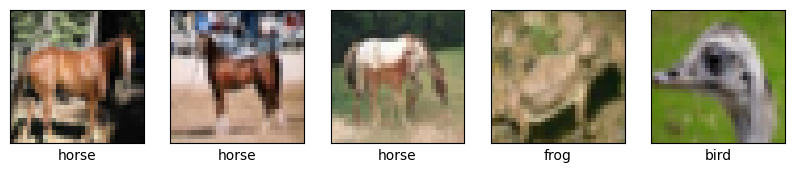

In [6]:
# Take some random examples, reshape to a 32x32 image and plot
from random import randint
fig, axes = plt.subplots(1, 5,  figsize=(10, 5))
for i in range(5):
    n = randint(0,len(Xr))
    # The data is stored in a 3x32x32 format, so we need to transpose it
    axes[i].imshow(Xr[n]/255)
    axes[i].set_xlabel((cifar_classes[int(y[n])]))
    axes[i].set_xticks(()), axes[i].set_yticks(())
plt.show();

## Exercise 1: A simple model
* Split the data into 80% training and 20% validation sets
* Normalize the data to [0,1]
* Build a ConvNet with 3 convolutional layers interspersed with MaxPooling layers, and one dense layer.
    * Use at least 32 3x3 filters in the first layer and ReLU activation.
    * Otherwise, make rational design choices or experiment a bit to see what works.
* You should at least get 60% accuracy.
* For training, you can try batch sizes of 64, and 20-50 epochs, but feel free to explore this as well
* Plot and interpret the learning curves. Is the model overfitting? How could you improve it further?

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


In [11]:
#  Normalize the data to [0,1]

X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255


In [15]:

X_train = X_train.reshape(-1, 32, 32, 3)
X_test = X_test.reshape(-1, 32, 32, 3)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(10, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, batch_size=64, epochs=20, validation_data=(X_test, y_test))


Epoch 1/20
250/250 [==============================] - 7s 6ms/step - loss: 1.9250 - accuracy: 0.2986 - val_loss: 1.7109 - val_accuracy: 0.3738
Epoch 2/20
250/250 [==============================] - 1s 4ms/step - loss: 1.6178 - accuracy: 0.4186 - val_loss: 1.5242 - val_accuracy: 0.4505
Epoch 3/20
250/250 [==============================] - 1s 4ms/step - loss: 1.5041 - accuracy: 0.4608 - val_loss: 1.4466 - val_accuracy: 0.4800
Epoch 4/20
250/250 [==============================] - 1s 4ms/step - loss: 1.4266 - accuracy: 0.4963 - val_loss: 1.4793 - val_accuracy: 0.4818
Epoch 5/20
250/250 [==============================] - 1s 4ms/step - loss: 1.3695 - accuracy: 0.5122 - val_loss: 1.3403 - val_accuracy: 0.5272
Epoch 6/20
250/250 [==============================] - 1s 5ms/step - loss: 1.3094 - accuracy: 0.5366 - val_loss: 1.3240 - val_accuracy: 0.5250
Epoch 7/20
250/250 [==============================] - 2s 6ms/step - loss: 1.2580 - accuracy: 0.5538 - val_loss: 1.3182 - val_accuracy: 0.5272
Epoch 

## Exercise 2: VGG-like model
* Implement a simplified VGG model by building 3 'blocks' of 2 convolutional layers each
* Do MaxPooling after each block
* The first block should use at least 32 filters, later blocks should use more
* You can use 3x3 filters
* Use zero-padding to be able to build a deeper model (see the `padding` attribute)
* Use a dense layer with at least 128 hidden nodes.
* You can use ReLU activations everywhere (where it makes sense)
* Plot and interpret the learning curves


In [46]:
# prompt: Implement a simplified VGG model by building 3 'blocks' of 2 convolutional layers each
# Do MaxPooling after each block
# The first block should use at least 32 filters, later blocks should use more
# You can use 3x3 filters
# Use zero-padding to be able to build a deeper model

model = tf.keras.Sequential()
# Block 1
model.add(tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# Block 2
model.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# Block 3
model.add(tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# Dense layers
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
best_model=model
activated_model=model.fit(X_train, y_train, batch_size=64, epochs=20, validation_data=(X_test, y_test))


Epoch 1/20
250/250 [==============================] - 4s 9ms/step - loss: 1.9374 - accuracy: 0.2876 - val_loss: 1.6759 - val_accuracy: 0.3970
Epoch 2/20
250/250 [==============================] - 2s 8ms/step - loss: 1.6211 - accuracy: 0.4073 - val_loss: 1.5604 - val_accuracy: 0.4358
Epoch 3/20
250/250 [==============================] - 2s 9ms/step - loss: 1.5052 - accuracy: 0.4491 - val_loss: 1.5040 - val_accuracy: 0.4363
Epoch 4/20
250/250 [==============================] - 2s 8ms/step - loss: 1.3926 - accuracy: 0.4906 - val_loss: 1.3775 - val_accuracy: 0.4910
Epoch 5/20
250/250 [==============================] - 2s 8ms/step - loss: 1.2956 - accuracy: 0.5272 - val_loss: 1.2875 - val_accuracy: 0.5288
Epoch 6/20
250/250 [==============================] - 2s 9ms/step - loss: 1.1963 - accuracy: 0.5639 - val_loss: 1.2886 - val_accuracy: 0.5428
Epoch 7/20
250/250 [==============================] - 2s 8ms/step - loss: 1.1003 - accuracy: 0.6012 - val_loss: 1.2400 - val_accuracy: 0.5533
Epoch 

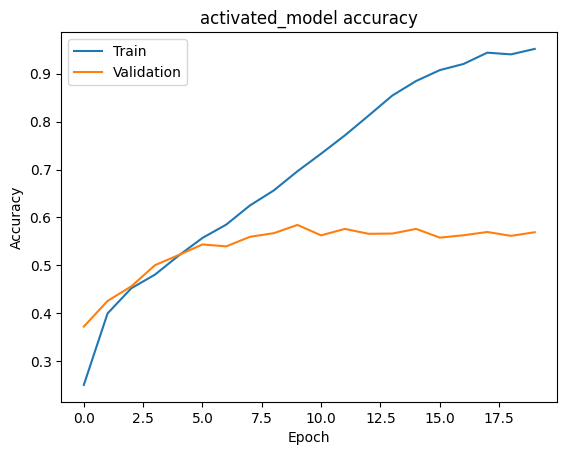

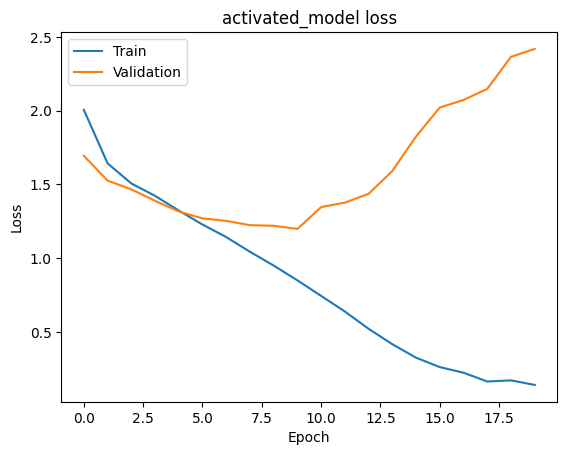

In [43]:
# prompt: Plot and interpret the learning curves

# Plot the learning curves
plt.plot(activated_model.history['accuracy'])
plt.plot(activated_model.history['val_accuracy'])
plt.title('activated_model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot the learning curves
plt.plot(activated_model.history['loss'])
plt.plot(activated_model.history['val_loss'])
plt.title('activated_model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


## Exercise 3: Regularization
* Explore different ways to regularize your VGG-like model
  * Try adding some dropout after every MaxPooling and Dense layer.
    * What are good Dropout rates? Try a fixed Dropout rate, or increase the rates in the deeper layers.
  * Try batch normalization together with Dropout
    * Think about where batch normalization would make sense
* Plot and interpret the learning curves


Epoch 1/20
250/250 [==============================] - 9s 15ms/step - loss: 2.4726 - accuracy: 0.2213 - val_loss: 2.7005 - val_accuracy: 0.1133
Epoch 2/20
250/250 [==============================] - 3s 13ms/step - loss: 1.9200 - accuracy: 0.3198 - val_loss: 1.8637 - val_accuracy: 0.3040
Epoch 3/20
250/250 [==============================] - 4s 15ms/step - loss: 1.7197 - accuracy: 0.3781 - val_loss: 1.6324 - val_accuracy: 0.3990
Epoch 4/20
250/250 [==============================] - 3s 14ms/step - loss: 1.6227 - accuracy: 0.4091 - val_loss: 1.5270 - val_accuracy: 0.4403
Epoch 5/20
250/250 [==============================] - 4s 16ms/step - loss: 1.5468 - accuracy: 0.4431 - val_loss: 1.5588 - val_accuracy: 0.4227
Epoch 6/20
250/250 [==============================] - 4s 14ms/step - loss: 1.4777 - accuracy: 0.4704 - val_loss: 1.4028 - val_accuracy: 0.4870
Epoch 7/20
250/250 [==============================] - 4s 14ms/step - loss: 1.4311 - accuracy: 0.4829 - val_loss: 1.4968 - val_accuracy: 0.4538

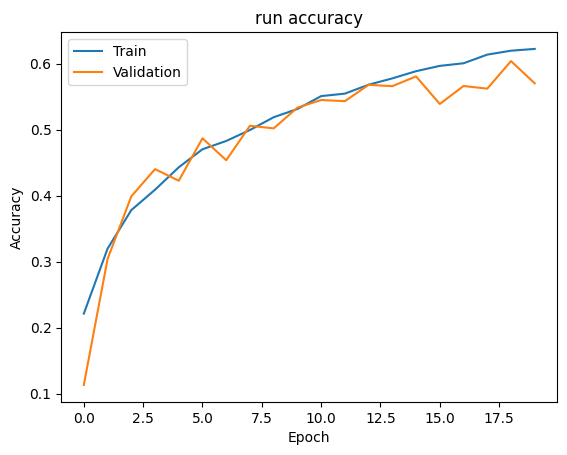

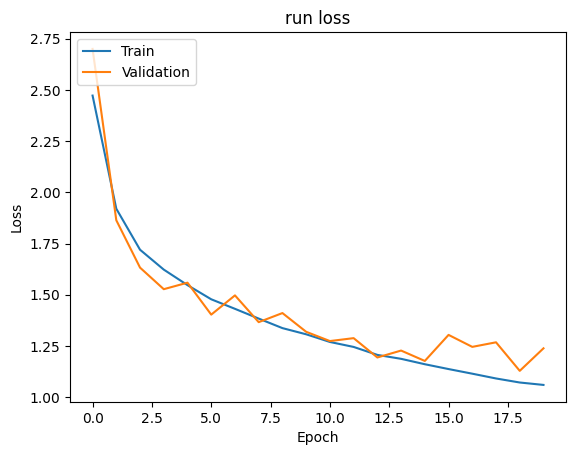

In [32]:
# prompt: Try adding some dropout after every MaxPooling and Dense layer
# Try batch normalization together with Dropout
# Plot and interpret the learning curves

model = tf.keras.Sequential()
# Block 1
model.add(tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# Block 2
model.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# Block 3
model.add(tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# Dense layers
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(10, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
run=model.fit(X_train, y_train, batch_size=64, epochs=20, validation_data=(X_test, y_test))


# Plot the learning curves
plt.plot(run.history['accuracy'])
plt.plot(run.history['val_accuracy'])
plt.title('run accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot the learning curves
plt.plot(run.history['loss'])
plt.plot(run.history['val_loss'])
plt.title('run loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


Lower both accuracy and val_loss with Dropout and BatchNormalization


## Exercise 4: Data Augmentation
* Perform image augmentation (rotation, shift, shear, zoom, flip,...). You can use the ImageDataGenerator for this.
* What is the effect? What is the effect with and without Dropout?
* Plot and interpret the learning curves


Epoch 1/20
250/250 [==============================] - 13s 45ms/step - loss: 1.7664 - accuracy: 0.3816 - val_loss: 1.9307 - val_accuracy: 0.3848
Epoch 2/20
250/250 [==============================] - 12s 47ms/step - loss: 1.6283 - accuracy: 0.4157 - val_loss: 1.7923 - val_accuracy: 0.3983
Epoch 3/20
250/250 [==============================] - 12s 47ms/step - loss: 1.5903 - accuracy: 0.4353 - val_loss: 3.0021 - val_accuracy: 0.2457
Epoch 4/20
250/250 [==============================] - 12s 47ms/step - loss: 1.5674 - accuracy: 0.4449 - val_loss: 2.0162 - val_accuracy: 0.3725
Epoch 5/20
250/250 [==============================] - 11s 46ms/step - loss: 1.5429 - accuracy: 0.4502 - val_loss: 1.8052 - val_accuracy: 0.4095
Epoch 6/20
250/250 [==============================] - 13s 53ms/step - loss: 1.5216 - accuracy: 0.4591 - val_loss: 2.2143 - val_accuracy: 0.3548
Epoch 7/20
250/250 [==============================] - 12s 48ms/step - loss: 1.5063 - accuracy: 0.4599 - val_loss: 2.0453 - val_accuracy:

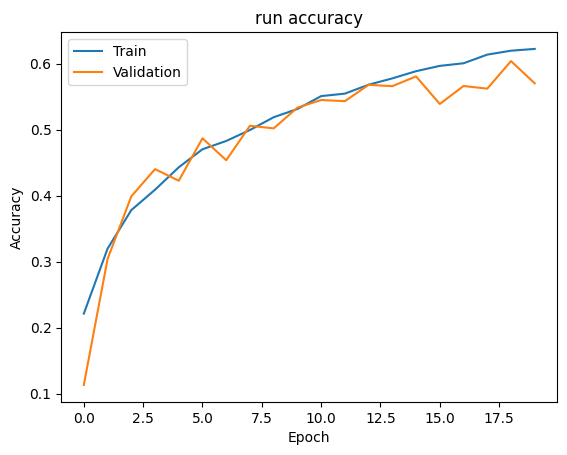

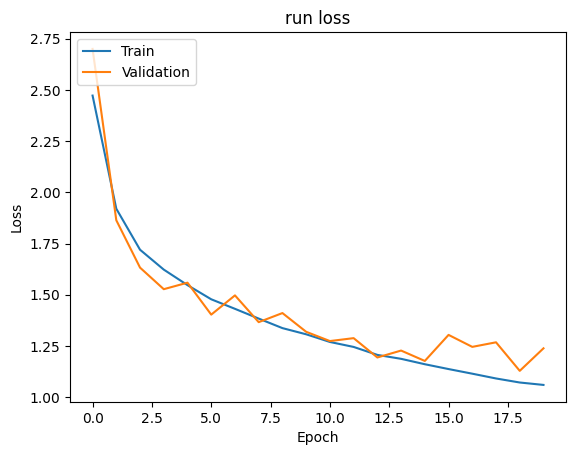

In [33]:
#with dropout

from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True)

datagen.fit(X_train)

model.fit(datagen.flow(X_train, y_train, batch_size=64), epochs=20, validation_data=(X_test, y_test))

# Plot the learning curves
plt.plot(run.history['accuracy'])
plt.plot(run.history['val_accuracy'])
plt.title('run accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot the learning curves
plt.plot(run.history['loss'])
plt.plot(run.history['val_loss'])
plt.title('run loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


Epoch 1/20
250/250 [==============================] - 20s 57ms/step - loss: 2.0009 - accuracy: 0.2835 - val_loss: 2.7988 - val_accuracy: 0.1822
Epoch 2/20
250/250 [==============================] - 11s 45ms/step - loss: 1.7941 - accuracy: 0.3536 - val_loss: 2.1166 - val_accuracy: 0.2707
Epoch 3/20
250/250 [==============================] - 11s 44ms/step - loss: 1.7038 - accuracy: 0.3853 - val_loss: 2.0939 - val_accuracy: 0.3517
Epoch 4/20
250/250 [==============================] - 11s 45ms/step - loss: 1.6218 - accuracy: 0.4176 - val_loss: 1.9223 - val_accuracy: 0.3587
Epoch 5/20
250/250 [==============================] - 12s 48ms/step - loss: 1.5823 - accuracy: 0.4304 - val_loss: 3.0311 - val_accuracy: 0.1845
Epoch 6/20
250/250 [==============================] - 10s 41ms/step - loss: 1.5277 - accuracy: 0.4493 - val_loss: 2.1925 - val_accuracy: 0.3180
Epoch 7/20
250/250 [==============================] - 23s 94ms/step - loss: 1.4891 - accuracy: 0.4672 - val_loss: 1.9821 - val_accuracy:

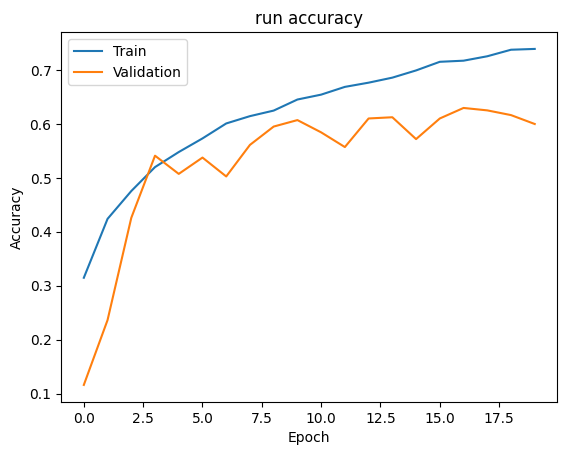

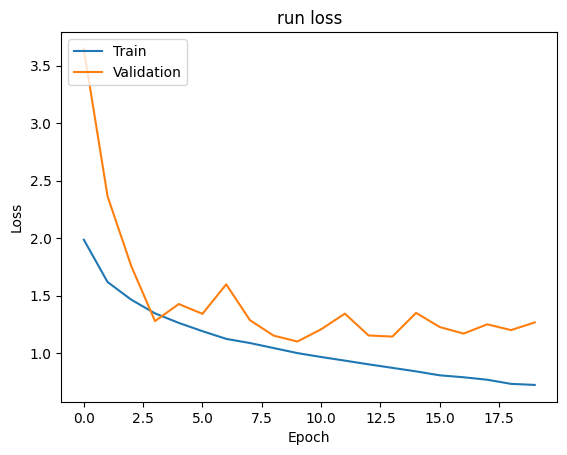

In [31]:
#without Dropout
model = tf.keras.Sequential()
# Block 1
model.add(tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# Block 2
model.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# Block 3
model.add(tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
# Dense layers
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(10, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(datagen.flow(X_train, y_train, batch_size=64), epochs=20, validation_data=(X_test, y_test))

# Plot the learning curves
plt.plot(run.history['accuracy'])
plt.plot(run.history['val_accuracy'])
plt.title('run accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot the learning curves
plt.plot(run.history['loss'])
plt.plot(run.history['val_loss'])
plt.title('run loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Without Dropout has higher performance

## Exercise 5: Interpret the misclassifications
Chances are that even your best model is not yet perfect. It is important to understand what kind of errors it still makes.
* Run the test images through the network and detect all misclassified ones
* Interpret some of the misclassifications. Are these misclassifications to be expected?
* Compute the confusion matrix. Which classes are often confused?

125/125 [==============================] - 0s 3ms/step
[[282  18   6   0   0   0  45   0   7  37]
 [  2 275   1   1   0   0  69   0   5  82]
 [ 75   9  97   5   3  11 180   3   3   6]
 [ 29  16  25  21   0  27 268   6   0  27]
 [ 39   5  24   2  16   2 290  13   0  11]
 [ 27   8  15  12   0  98 214   3   4  13]
 [  8   2   2   0   0   0 349   0   1   1]
 [ 37   8  10   5   2  22 170 104   0  38]
 [184  34   5   0   1   1  51   0  73  62]
 [ 14  36   0   3   0   2  66   0   0 272]]


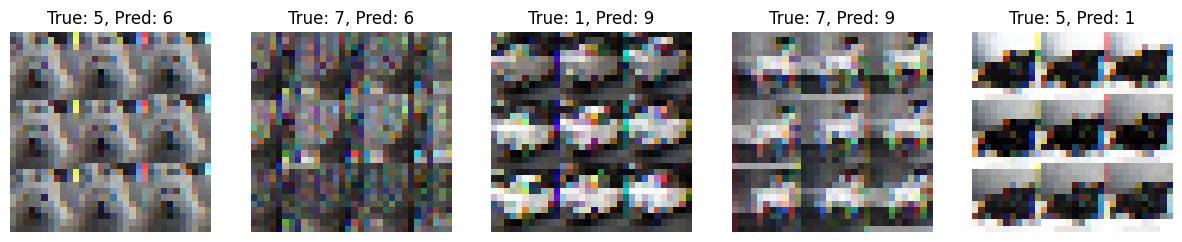

In [39]:

y_pred = model.predict(X_test)
misclassified_indices = []
for i in range(len(y_pred)):
    predicted_label = np.argmax(y_pred[i])
    if predicted_label != y_test[i]:
        misclassified_indices.append(i)




# Compute the confusion matrix. Which classes are often confused?
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, np.argmax(y_pred, axis=1))
print(cm)

num_images_to_show = 5  # Adjust the number of images to show
fig, axes = plt.subplots(1, num_images_to_show, figsize=(15, 5))

for idx, ax in zip(misclassified_indices[:num_images_to_show], axes):
    ax.imshow(X_test[idx])
    true_label = y_test[idx]
    predicted_label = np.argmax(y_pred[idx])
    ax.set_title(f"True: {true_label}, Pred: {predicted_label}")
    ax.axis('off')

plt.show()

## Exercise 6: Interpret the model
Retrain your best model on all the data. Next, retrieve and visualize the activations (feature maps) for every filter for every convolutional layer, or at least for a few filters for every layer. Tip: see the course notebooks for examples on how to do this.

Interpret the results. Is your model indeed learning something useful?

In [52]:
import tensorflow as tf

# Extract outputs from each convolutional layer
layer_outputs = [layer.output for layer in best_model.layers if isinstance(layer, tf.keras.layers.Conv2D)]

# Create a model that will return these outputs, given the model input
activation_model = tf.keras.models.Model(inputs=best_model.input, outputs=layer_outputs)


In [53]:
import numpy as np

# Example: using an image from X_test and ensuring it's properly preprocessed
# Assuming X_test is already preprocessed if needed
img_tensor = np.expand_dims(X_test[0], axis=0)

In [54]:
activations = activation_model.predict(img_tensor)

1/1 [==============================] - 0s 165ms/step


<ipython-input-56-99bcccdc3e6e>:24: RuntimeWarning: invalid value encountered in cast
  channel_image = np.clip(channel_image, 0, 255).astype('uint8')
<ipython-input-56-99bcccdc3e6e>:21: RuntimeWarning: invalid value encountered in divide
  channel_image /= channel_image.std()


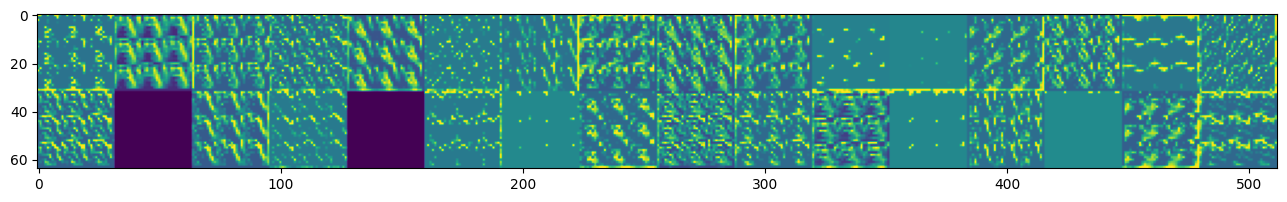

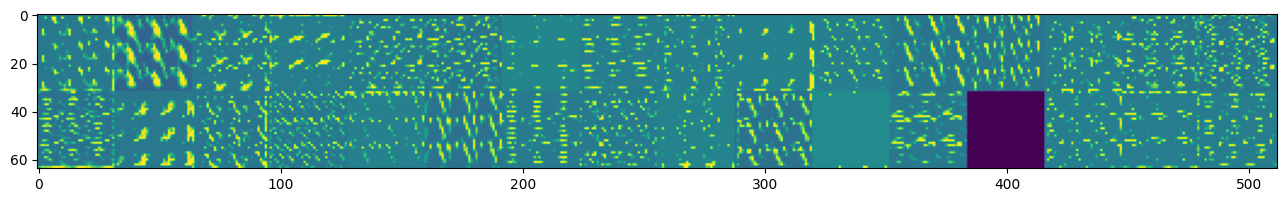

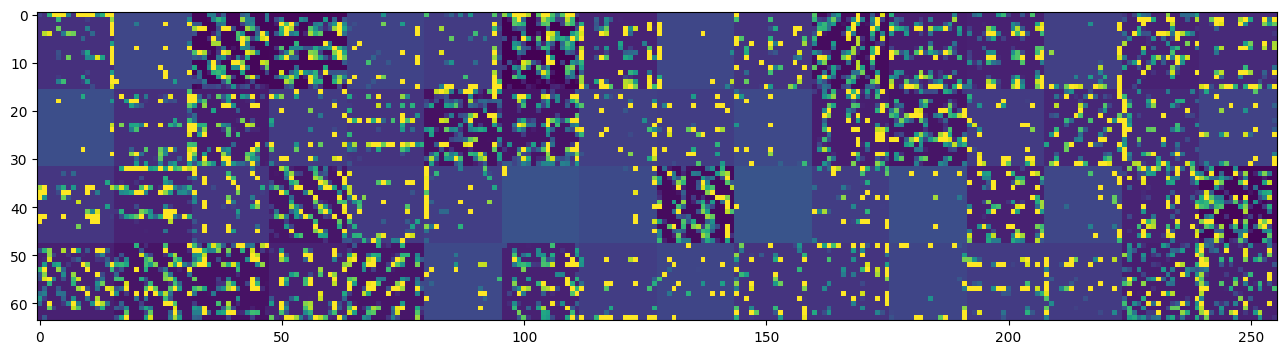

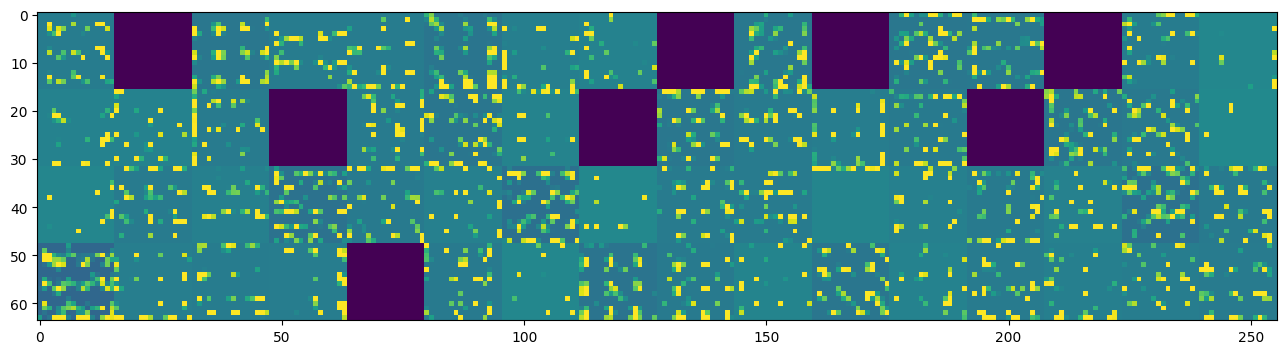

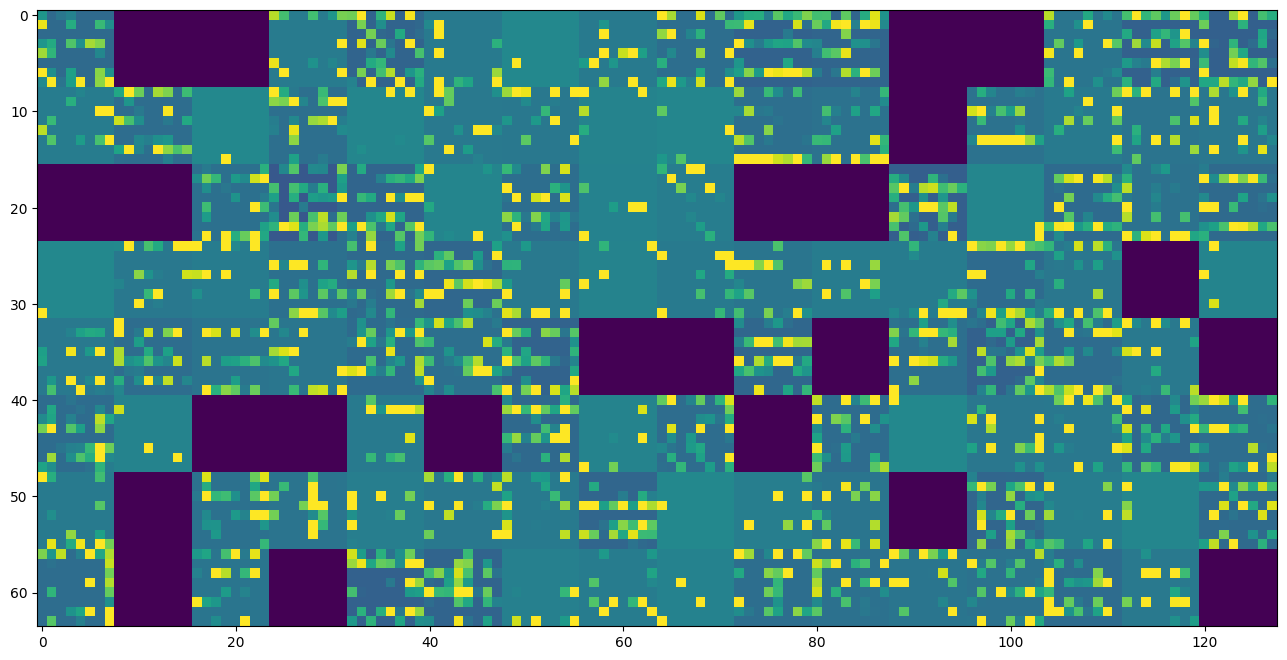

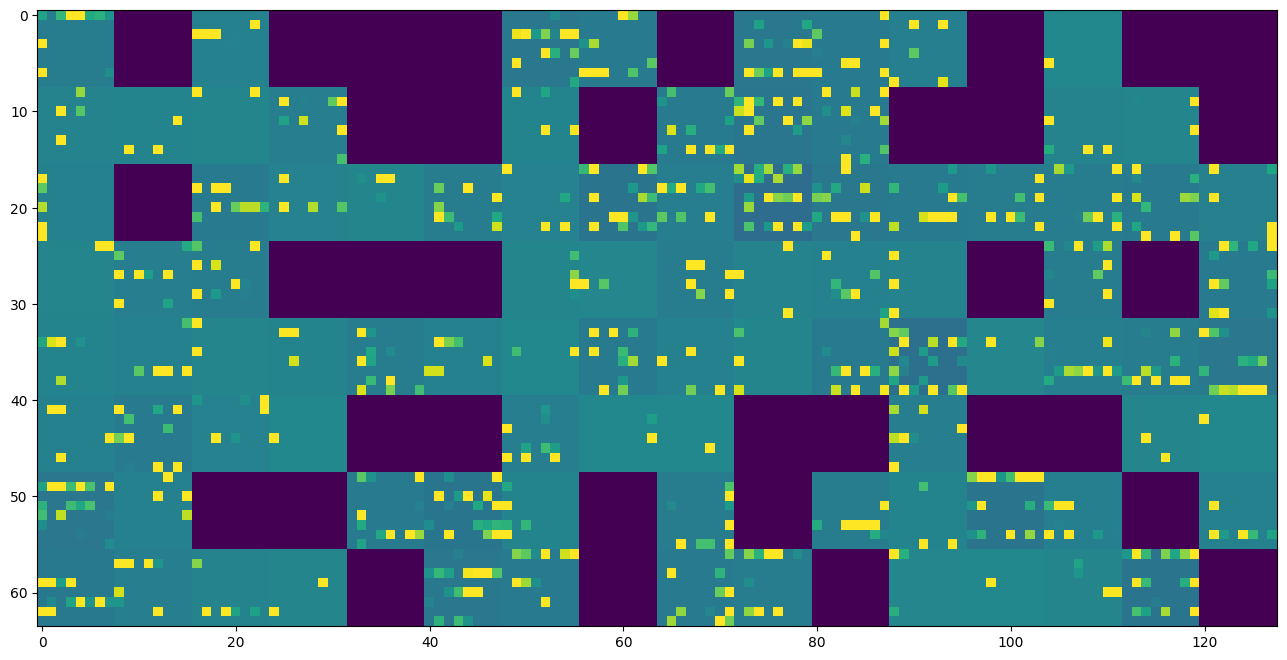

In [56]:
import matplotlib.pyplot as plt

# Visualize the feature maps for each convolutional layer output
for layer_activation in activations:
    # Number of features in the feature map
    num_features = layer_activation.shape[-1]

    # The feature map has shape (1, size, size, num_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = num_features // 16  # Adjust the number of columns displayed to prevent too wide visualization
    display_grid = np.zeros((size * n_cols, size * 16))

    for col in range(n_cols):
        for row in range(16):
            if col * 16 + row < num_features:
                channel_image = layer_activation[0, :, :, col * 16 + row]
                # Post-process the feature to make it visually palatable
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                # Display the grid
                display_grid[col * size : (col + 1) * size, row * size : (row + 1) * size] = channel_image

    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))

    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

plt.show()


## Optional: Take it a step further
* Repeat the exercises, but now use a [higher-resolution version of the CIFAR dataset](https://www.openml.org/d/40926) (with OpenML ID 41103), or another [version with 100 classes](https://www.openml.org/d/41983) (with OpenML ID 41983). Good luck!
